In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pylab as pl
import seaborn as sns

In [13]:
df = pd.read_csv("/mnt/data/ML-Ready/mixed_data/outputs/best_val_loss_res.csv")

In [3]:
df2 = pd.read_csv("/mnt/data/ML-Ready/flares_event_dir/outputs/outputs_best_checkpoint.csv")

In [19]:
df3 = pd.read_csv("/mnt/data/ML-Ready/flares_event_dir/outputs/testing.csv")

In [3]:
print(df.head())

             Timestamp  Predictions  ground_truth
0  2023-08-01T00:00:00     0.000004      0.000003
1  2023-08-01T00:01:00     0.000005      0.000003
2  2023-08-01T00:02:00     0.000005      0.000003
3  2023-08-01T00:03:00     0.000005      0.000003
4  2023-08-01T00:04:00     0.000005      0.000003


In [10]:
df['Timestamp'] = pd.to_datetime(df['Timestamp'], format='%Y-%m-%dT%H:%M:%S')
# df2['Timestamp'] = pd.to_datetime(df2['Timestamp'], format='%Y-%m-%dT%H:%M:%S')
# df3['Timestamp'] = pd.to_datetime(df3['Timestamp'], format='%Y-%m-%dT%H:%M:%S', errors='coerce')

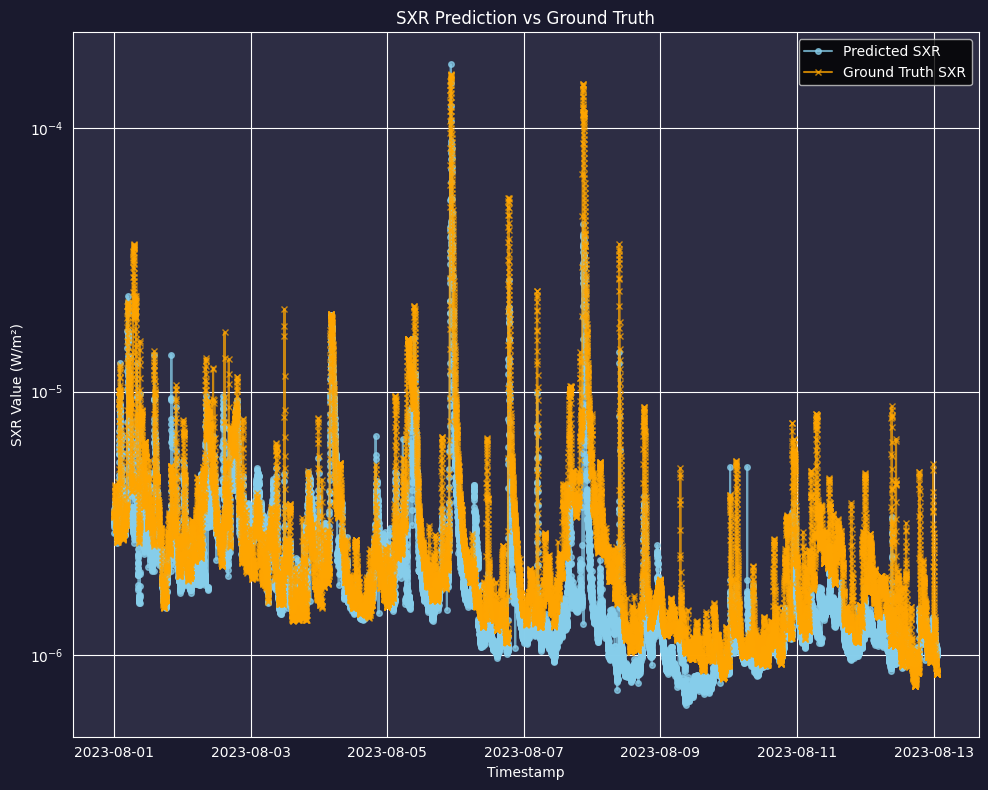

In [11]:
plt.style.use('dark_background')
sns.set_palette("husl")

df = df.sort_values(by='Timestamp')

# Plot
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
fig.patch.set_facecolor('#1a1a2e')
ax.set_facecolor('#2d2d44')
plt.plot(df['Timestamp'], df['Predictions'], label='Predicted SXR', marker='o',markersize=4,alpha=.75,c='skyblue')
plt.plot(df['Timestamp'], df['ground_truth'], label='Ground Truth SXR', marker='x',markersize=4,alpha=.75,c='orange')
plt.xlabel("Timestamp")
plt.ylabel("SXR Value (W/m²)")
plt.title("SXR Prediction vs Ground Truth")
#plt.xlim(pd.to_datetime("2023-08-01T00:00:00"), pd.to_datetime("2023-08-2T00:00:00"))

plt.yscale('log')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.xticks(rotation=0)
plt.show()

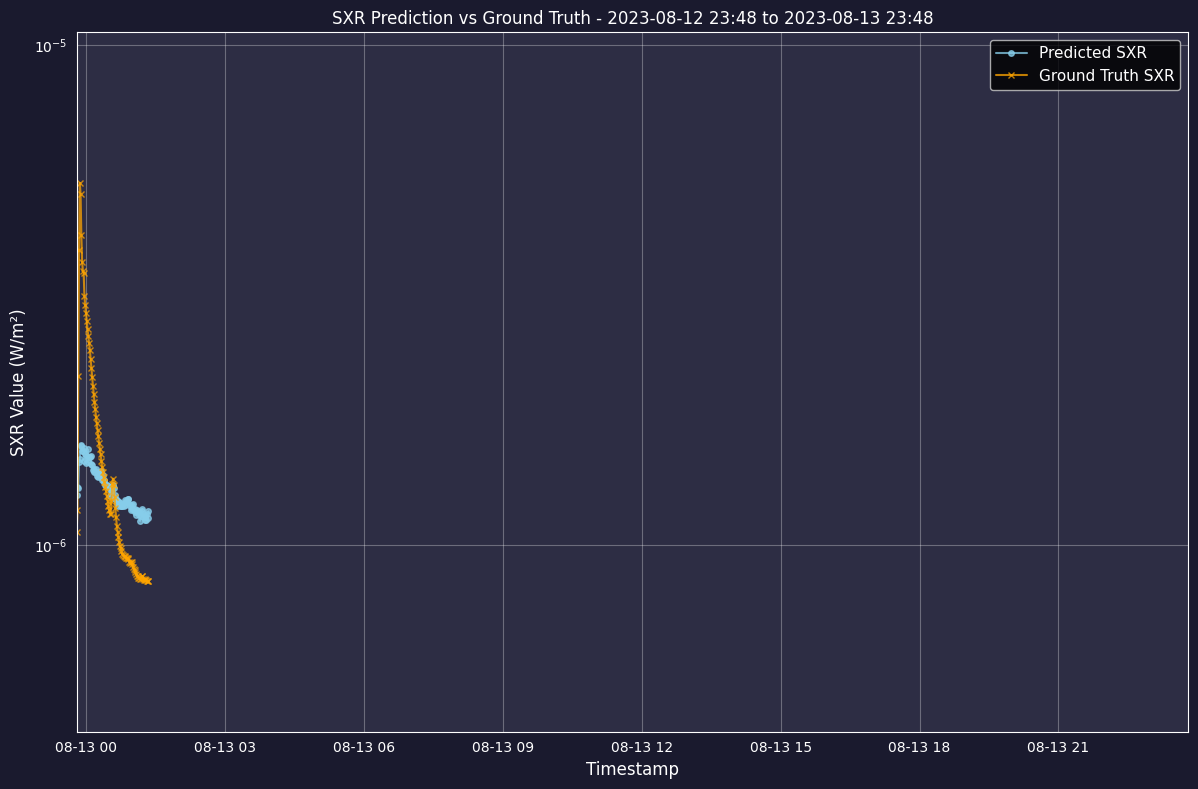

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from matplotlib.animation import FuncAnimation
from datetime import datetime, timedelta

# Set style
plt.style.use('dark_background')
sns.set_palette("husl")

# Ensure df is sorted by timestamp
df = df.sort_values(by='Timestamp')

# Convert timestamps to datetime if they aren't already
df['Timestamp'] = pd.to_datetime(df['Timestamp'])

# Define date range for the animation
start_date = pd.to_datetime("2023-08-01T00:00:00")
end_date = pd.to_datetime("2023-08-13T23:59:59")


# Define step size for smooth animation
step_hours = .2 # Move window by 0.05 hours (3 minutes) each frame

# Calculate number of frames correctly
# We want the window to slide from start_date to (end_date - 1 day)
# so the last frame shows end_date-1day to end_date
animation_duration_hours = (end_date - start_date - timedelta(days=1)).total_seconds() / 3600
n_frames = int(animation_duration_hours / step_hours) + 1


# Create figure and axis
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
fig.patch.set_facecolor('#1a1a2e')
ax.set_facecolor('#2d2d44')

# Initialize empty line objects
line_pred, = ax.plot([], [], label='Predicted SXR', marker='o', markersize=4, alpha=0.75, c='skyblue')
line_truth, = ax.plot([], [], label='Ground Truth SXR', marker='x', markersize=4, alpha=0.75, c='orange')

# Set up the plot
ax.set_xlabel("Timestamp", fontsize=12)
ax.set_ylabel("SXR Value (W/m²)", fontsize=12)
ax.set_title("SXR Prediction vs Ground Truth - Rolling 1-Day Window", fontsize=14)
ax.set_yscale('log')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)

def animate(frame):
    # Calculate the current window start time (moving by step_hours each frame)
    window_start = start_date + timedelta(hours=frame * step_hours)
    window_end = window_start + timedelta(days=1)  # Always 24-hour window

    # Filter data for current window
    mask = (df['Timestamp'] >= window_start) & (df['Timestamp'] < window_end)
    window_df = df[mask]

    if len(window_df) > 0:
        # Update line data
        line_pred.set_data(window_df['Timestamp'], window_df['Predictions'])
        line_truth.set_data(window_df['Timestamp'], window_df['ground_truth'])

        # Set axis limits
        ax.set_xlim(window_start, window_end)

        # Dynamic y-axis limits based on current window data
        all_values = pd.concat([window_df['Predictions'], window_df['ground_truth']])
        if len(all_values) > 0:
            y_min = all_values.min() * 0.5
            y_max = all_values.max() * 2
            ax.set_ylim(y_min, y_max)

    # Update title with current date and time
    ax.set_title(f"SXR Prediction vs Ground Truth - {window_start.strftime('%Y-%m-%d %H:%M')} to {window_end.strftime('%Y-%m-%d %H:%M')}", fontsize=12)

    # Format x-axis ticks
    ax.tick_params(axis='x', rotation=0)

    return line_pred, line_truth

# Create animation
# Now we have many more frames for smooth transition
anim = FuncAnimation(fig, animate, frames=n_frames, interval=50, blit=False, repeat=True)

plt.tight_layout()

# Save as MP4 (requires ffmpeg) - higher fps for smooth playback
# anim.save('sxr_rolling_window.mp4', writer='ffmpeg', fps=20, bitrate=1800)

# Save as GIF (alternative) - higher fps for smooth playback
anim.save('sxr_rolling_window_baseline_mixed.gif', writer='pillow', fps=10)

plt.show()

# To save the animation, uncomment one of the save lines above
# Make sure you have ffmpeg installed for MP4 or use the GIF option
# Note: The animation will be much longer now due to the smooth transitions

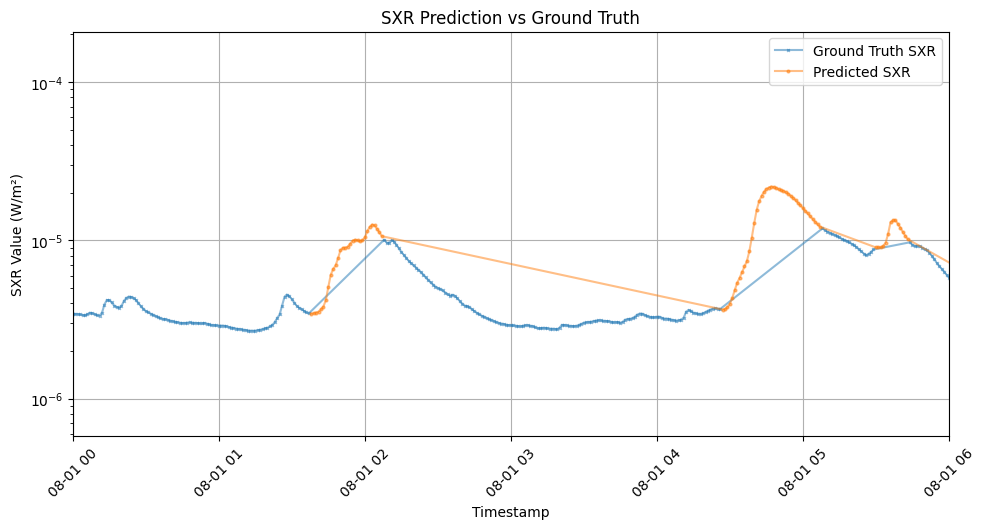

In [25]:
df = df.sort_values(by='Timestamp')

# Plot
plt.figure(figsize=(10, 5))
#plt.plot(df['Timestamp'], df['Predictions'], label='Predicted SXR', marker='o',markersize=2,alpha=.5)
plt.plot(df['Timestamp'], df['ground_truth'], label='Ground Truth SXR', marker='x',markersize=2,alpha=.5)
plt.plot(df3['Timestamp'], df3['ground_truth'], label='Predicted SXR', marker='o',markersize=2,alpha=.5)
#plt.plot(df2['Timestamp'], df2['Predictions'], label='Predicted SXR Best Checkpoint', marker='o',markersize=2,alpha=.5)
plt.xlabel("Timestamp")
plt.ylabel("SXR Value (W/m²)")
plt.title("SXR Prediction vs Ground Truth")
plt.xlim(pd.to_datetime("2023-08-01T00:00:00"), pd.to_datetime("2023-08-1T06:00:00"))
plt.yscale('log')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.xticks(rotation=45)
plt.show()

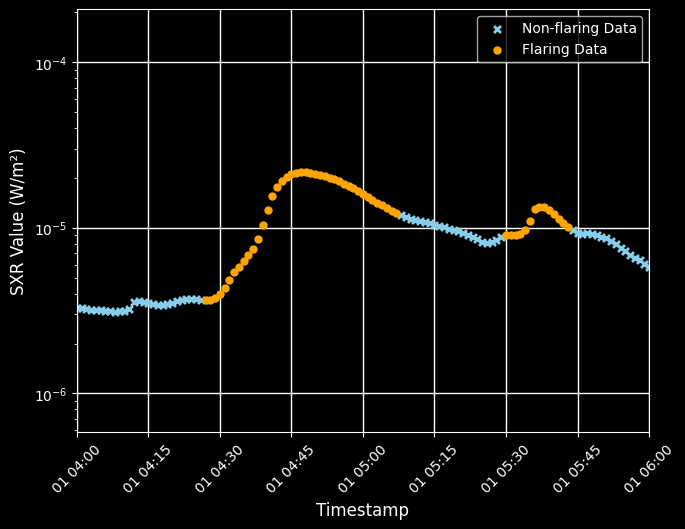

In [43]:
plt.style.use('dark_background')
df = df.sort_values(by='Timestamp')

# Filter out NaN, None, infinite values, and values <= 0 (for log scale)
df_clean = df[df['ground_truth'].notna() & np.isfinite(df['ground_truth']) & (df['ground_truth'] > 0)]
df3_clean = df3[df3['ground_truth'].notna() & np.isfinite(df3['ground_truth']) & (df3['ground_truth'] > 0)]

# Plot
plt.figure(figsize=(7, 5))
#plt.plot(df['Timestamp'], df['Predictions'], label='Predicted SXR', marker='o',markersize=2,alpha=.5)
# Option 1: Use scatter plot instead of line plot to avoid connecting points
plt.scatter(df_clean['Timestamp'], df_clean['ground_truth'], label='Non-flaring Data', marker='x', s=25, alpha=1, c='skyblue')
plt.scatter(df3_clean['Timestamp'], df3_clean['ground_truth'], label='Flaring Data', marker='o', s=25, alpha=1, c='orange')


plt.xlabel("Timestamp")
plt.ylabel("SXR Value (W/m²)")
#plt.title("SXR Prediction vs Ground Truth")
plt.xlim(pd.to_datetime("2023-08-01T04:00:00"), pd.to_datetime("2023-08-1T06:00:00"))
plt.yscale('log')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.xticks(rotation=45)
plt.show()

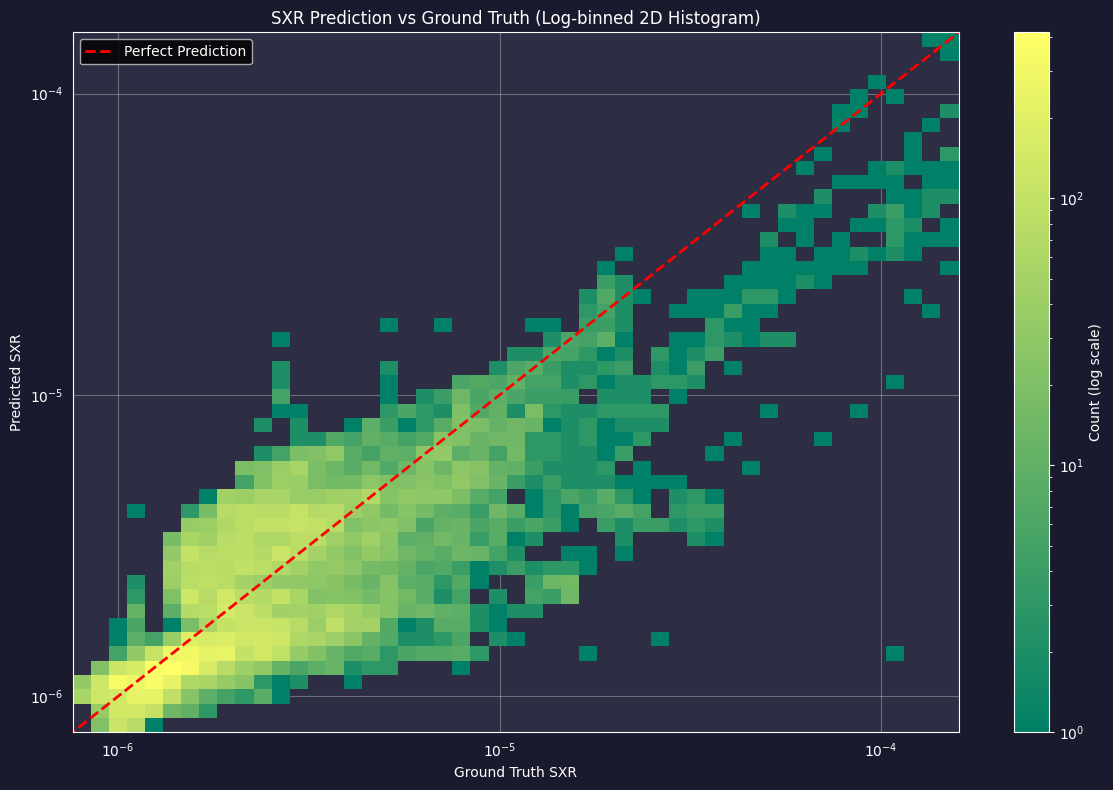

In [15]:

import matplotlib.pyplot as plt
import numpy as np


# Enhanced version with better log scale handling

fig, ax = plt.subplots(1, 1, figsize=(12, 8))
fig.patch.set_facecolor('#1a1a2e')
ax.set_facecolor('#2d2d44')

# Create log-spaced bins for better visualization with log scale
log_bins = np.logspace(np.log10(df['ground_truth'].min()),
                       np.log10(df['ground_truth'].max()), 50)

plt.hist2d(df['ground_truth'], df['Predictions'],
           bins=[log_bins, log_bins], cmap='summer', norm='log')
plt.colorbar(label='Count (log scale)')

# Add equality line
min_val = min(df['ground_truth'].min(), df['Predictions'].min())
max_val = max(df['ground_truth'].max(), df['Predictions'].max())
plt.plot([min_val, max_val], [min_val, max_val],
         label='Perfect Prediction', color='red', linestyle='--', linewidth=2,)

plt.xlabel("Ground Truth SXR")
plt.ylabel("Predicted SXR")
plt.title("SXR Prediction vs Ground Truth (Log-binned 2D Histogram)")
plt.xscale("log")
plt.yscale("log")
plt.legend()
plt.grid(True, alpha=0.3, color='white')
plt.tight_layout()
plt.savefig('sxr_prediction_vs_ground_truth_histogram_mixed.png', dpi=500, bbox_inches='tight',)
plt.show()

In [9]:
df3 = pd.read_csv("/mnt/data/goes_combined/combined_g18_avg1m_20230701_20230815.csv")

In [3]:
print(df3.head())

                  time  quad_diode     xrsa_flux  xrsa_flux_observed  \
0  2023-07-01 00:00:00           0  3.819575e-08        1.292294e-07   
1  2023-07-01 00:01:00           0  3.934445e-08        1.302223e-07   
2  2023-07-01 00:02:00           0  3.559045e-08        1.259449e-07   
3  2023-07-01 00:03:00           0  3.629261e-08        1.304600e-07   
4  2023-07-01 00:04:00           0  4.002771e-08        1.364038e-07   

   xrsa_flux_electrons  xrsb_flux  xrsb_flux_observed  xrsb_flux_electrons  \
0         9.103358e-08   0.000001            0.000002         6.243999e-08   
1         9.087783e-08   0.000001            0.000002         6.195026e-08   
2         9.035446e-08   0.000001            0.000002         6.178886e-08   
3         9.416739e-08   0.000001            0.000002         6.366041e-08   
4         9.637610e-08   0.000001            0.000002         6.706021e-08   

   xrsa_flag  xrsb_flag  ...  xrsb2_flag  xrsa1_num  xrsa2_num  xrsb1_num  \
0        4.0        0

In [10]:
df3['time'] = pd.to_datetime(df3['time'], format='%Y-%m-%d %H:%M:%S', errors='coerce')

In [8]:
print(df3.head())

  time  quad_diode     xrsa_flux  xrsa_flux_observed  xrsa_flux_electrons  \
0  NaT           0  3.819575e-08        1.292294e-07         9.103358e-08   
1  NaT           0  3.934445e-08        1.302223e-07         9.087783e-08   
2  NaT           0  3.559045e-08        1.259449e-07         9.035446e-08   
3  NaT           0  3.629261e-08        1.304600e-07         9.416739e-08   
4  NaT           0  4.002771e-08        1.364038e-07         9.637610e-08   

   xrsb_flux  xrsb_flux_observed  xrsb_flux_electrons  xrsa_flag  xrsb_flag  \
0   0.000001            0.000002         6.243999e-08        4.0        0.0   
1   0.000001            0.000002         6.195026e-08        4.0        0.0   
2   0.000001            0.000002         6.178886e-08        4.0        0.0   
3   0.000001            0.000002         6.366041e-08        4.0        0.0   
4   0.000001            0.000002         6.706021e-08        4.0        0.0   

   ...  xrsb2_flag  xrsa1_num  xrsa2_num  xrsb1_num  xrsb2_num

In [5]:
df3 =df3[df3['quad_diode']==0]

In [6]:
print(df3['xrsb_flux'])

0        1.441284e-06
1        1.479226e-06
2        1.451601e-06
3        1.450579e-06
4        1.451790e-06
             ...     
66235    9.944554e-07
66236    1.002282e-06
66237    1.027455e-06
66238    1.045159e-06
66239    1.053440e-06
Name: xrsb_flux, Length: 66240, dtype: float64


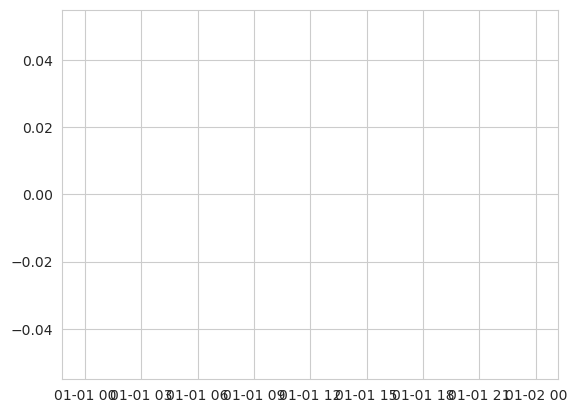

In [7]:
plt.plot(df3['time'], df3['xrsb_flux'], label='GOES XRS-B Flux', color='darkblue')

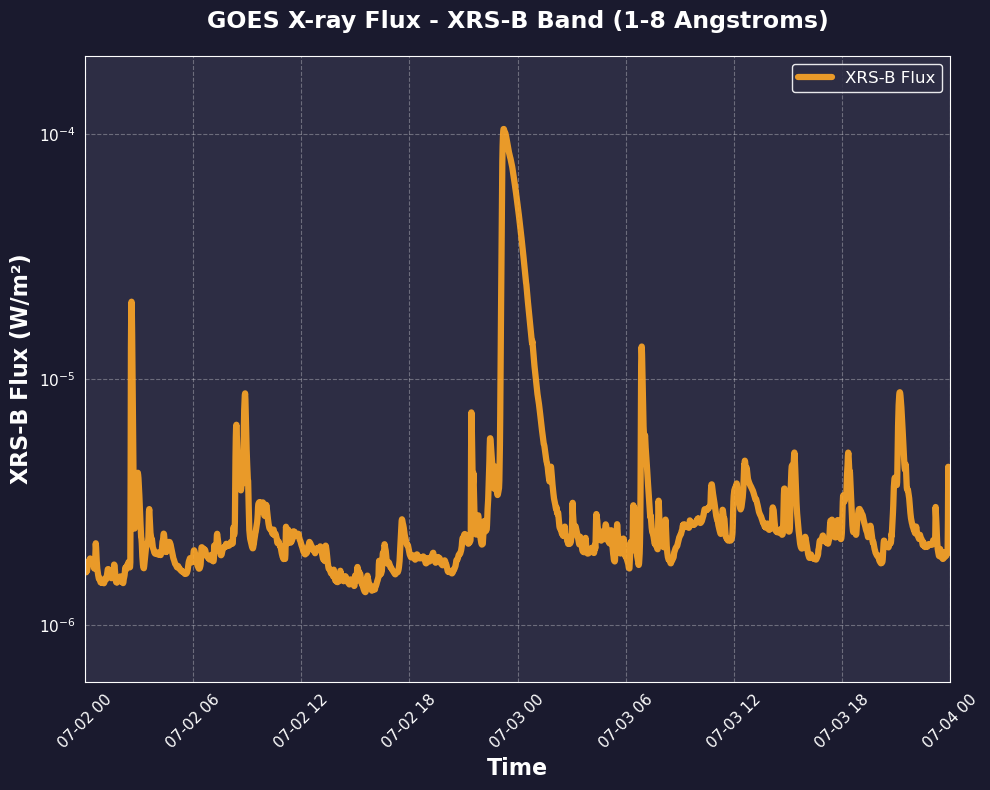

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
import seaborn as sns

# Set the style for dark theme with block background
plt.style.use('dark_background')
sns.set_palette("husl")

# Assuming you have your DataFrame as 'df'
# df = pd.read_csv('your_solar_data.csv')  # Load your actual data
# df['time'] = pd.to_datetime(df['time'])  # Convert time to datetime

# Create the plot with block background
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
fig.patch.set_facecolor('#1a1a2e')
ax.set_facecolor('#2d2d44')

# Define colors for different XRSB flux types
colors = {
    'xrsb_flux': '#ffa726',           # Orange
    'xrsb_flux_observed': '#66bb6a',  # Green
    'xrsb_flux_electrons': '#ab47bc'  # Purple
}

# Plot XRSB data (replace with your actual df columns)
# ax.plot(df['time'], df['xrsb_flux'], color=colors['xrsb_flux'],
#         linewidth=2.5, label='XRSB Flux', alpha=0.9)
# ax.plot(df['time'], df['xrsb_flux_observed'], color=colors['xrsb_flux_observed'],
#         linewidth=2, label='XRSB Observed', alpha=0.8)
# ax.plot(df['time'], df['xrsb_flux_electrons'], color=colors['xrsb_flux_electrons'],
#         linewidth=2, label='XRSB Electrons', alpha=0.8)

# Sample data for demonstration (remove when using real data)
# 5-minute intervals for 24 hours

# Plot the data
ax.plot(df3['time'], df3['xrsb_flux'], color=colors['xrsb_flux'], label='XRS-B Flux', alpha=0.9, linewidth=4.5)

plt.yscale('log')
# Customize the plot
ax.grid(True, alpha=0.3, linestyle='--', color='white')
ax.set_ylabel('XRS-B Flux (W/m²)', fontsize=16, color='white', fontweight='bold')
ax.set_xlabel('Time', fontsize=16, color='white', fontweight='bold')
ax.set_title('GOES X-ray Flux - XRS-B Band (1-8 Angstroms)',
             fontsize=17, color='white', fontweight='bold', pad=20)


plt.xlim(pd.to_datetime("2023-07-02"), pd.to_datetime("2023-07-04"))
# # Format legend
legend = ax.legend(loc='upper right', framealpha=0.9, facecolor='#2d2d44',
                  edgecolor='white', fontsize=12)
# legend.get_frame().set_linewidth(1)

# Format ticks
ax.tick_params(axis='both', colors='white', labelsize=11)
ax.tick_params(axis='x', rotation=45)

# Format spines
# for spine in ax.spines.values():
#     spine.set_color('white')
#     spine.set_linewidth(1)



plt.tight_layout()

# Optional: Save the plot
# plt.savefig('xrsb_flux_plot.png', dpi=300, bbox_inches='tight',
#             facecolor='#1a1a2e', edgecolor='none')
plt.savefig('xrsb_flux_plot.png', dpi=500, bbox_inches='tight',
            facecolor='none', edgecolor='none')
plt.show()
